
<div class="alert alert-info">

**This is a fixed-text formatted version of a Jupyter notebook**

- Try online [![Binder](https://static.mybinder.org/badge.svg)](https://mybinder.org/v2/gh/gammapy/gammapy-webpage/master?urlpath=lab/tree/analysis_2.ipynb)
- You can contribute with your own notebooks in this
[GitHub repository](https://github.com/gammapy/gammapy/tree/master/docs/tutorials).
- **Source files:**
[analysis_2.ipynb](../_static/notebooks/analysis_2.ipynb) |
[analysis_2.py](../_static/notebooks/analysis_2.py)
</div>


# First analysis with gammapy library API

## Prerequisites:

- Understanding the gammapy data workflow, in particular what are DL3 events and intrument response functions (IRF).
- Understanding of the data reduction and modeling fitting process as shown in the [first gammapy analysis with the high level interface tutorial](analysis_1.ipynb)

## Context

This notebook is an introduction to gammapy analysis this time using the lower level classes and functions
the library.
This allows to understand what happens during two main gammapy analysis steps, data reduction and modeling/fitting. 

**Objective: Create a 3D dataset of the Crab using the H.E.S.S. DL3 data release 1 and perform a simple model fitting of the Crab nebula using the lower level gammapy API.**

## Proposed approach:

Here, we have to interact with the data archive (with the `~gammapy.data.DataStore`) to retrieve a list of selected observations (`~gammapy.data.Observations`). Then, we define the geometry of the `~gammapy.datasets.MapDataset` object we want to produce and the maker object that reduce an observation
to a dataset. 

We can then proceed with data reduction with a loop over all selected observations to produce datasets in the relevant geometry and stack them together (i.e. sum them all).

In practice, we have to:
- Create a `~gammapy.data.DataStore` poiting to the relevant data 
- Apply an observation selection to produce a list of observations, a `~gammapy.data.Observations` object.
- Define a geometry of the Map we want to produce, with a sky projection and an energy range.
    - Create a `~gammapy.maps.MapAxis` for the energy
    - Create a `~gammapy.maps.WcsGeom` for the geometry
- Create the necessary makers : 
    - the map dataset maker : `~gammapy.makers.MapDatasetMaker`
    - the background normalization maker, here a `~gammapy.makers.FoVBackgroundMaker`
    - and usually the safe range maker : `~gammapy.makers.SafeRangeMaker`
- Perform the data reduction loop. And for every observation:
    - Apply the makers sequentially to produce the current `~gammapy.datasets.MapDataset`
    - Stack it on the target one.
- Define the `~gammapy.modeling.models.SkyModel` to apply to the dataset.
- Create a `~gammapy.modeling.Fit` object and run it to fit the model parameters
- Apply a `~gammapy.estimators.FluxPointsEstimator` to compute flux points for the spectral part of the fit.

## Setup
First, we setup the analysis by performing required imports.


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from pathlib import Path
from astropy import units as u
from astropy.coordinates import SkyCoord
from regions import CircleSkyRegion

In [3]:
from gammapy.data import DataStore
from gammapy.datasets import MapDataset
from gammapy.maps import WcsGeom, MapAxis, Map
from gammapy.makers import MapDatasetMaker, SafeMaskMaker, FoVBackgroundMaker
from gammapy.modeling.models import (
    SkyModel,
    PowerLawSpectralModel,
    PointSpatialModel,
)
from gammapy.modeling import Fit
from gammapy.estimators import FluxPointsEstimator

## Defining the datastore and selecting observations

We first use the `~gammapy.data.DataStore` object to access the observations we want to analyse. Here the H.E.S.S. DL3 DR1. 

In [4]:
data_store = DataStore.from_dir("$GAMMAPY_DATA/hess-dl3-dr1")

We can now define an observation filter to select only the relevant observations. 
Here we use a cone search which we define with a python dict.

We then filter the `ObservationTable` with `~gammapy.data.ObservationTable.select_observations()`.

In [5]:
selection = dict(
    type="sky_circle",
    frame="icrs",
    lon="83.633 deg",
    lat="22.014 deg",
    radius="5 deg",
)
selected_obs_table = data_store.obs_table.select_observations(selection)

We can now retrieve the relevant observations by passing their `obs_id` to the`~gammapy.data.DataStore.get_observations()` method.

In [6]:
observations = data_store.get_observations(selected_obs_table["OBS_ID"])

## Preparing reduced datasets geometry

Now we define a reference geometry for our analysis, We choose a WCS based geometry with a binsize of 0.02 deg and also define an energy axis: 

In [7]:
energy_axis = MapAxis.from_energy_bounds(1.0, 10.0, 4, unit="TeV")

geom = WcsGeom.create(
    skydir=(83.633, 22.014),
    binsz=0.02,
    width=(2, 2),
    frame="icrs",
    proj="CAR",
    axes=[energy_axis],
)

# Reduced IRFs are defined in true energy (i.e. not measured energy).
energy_axis_true = MapAxis.from_energy_bounds(
    0.5, 20, 10, unit="TeV", name="energy_true"
)

Now we can define the target dataset with this geometry.

In [8]:
stacked = MapDataset.create(
    geom=geom, energy_axis_true=energy_axis_true, name="crab-stacked"
)

## Data reduction

### Create the maker classes to be used

The `~gammapy.datasets.MapDatasetMaker` object is initialized as well as the `~gammapy.makers.SafeMaskMaker` that carries here a maximum offset selection.

In [9]:
offset_max = 2.5 * u.deg
maker = MapDatasetMaker()
maker_safe_mask = SafeMaskMaker(methods=["offset-max"], offset_max=offset_max)

In [10]:
circle = CircleSkyRegion(
    center=SkyCoord("83.63 deg", "22.14 deg"), radius=0.2 * u.deg
)
data = geom.region_mask(regions=[circle], inside=False)
exclusion_mask = Map.from_geom(geom=geom, data=data)
maker_fov = FoVBackgroundMaker(method="fit", exclusion_mask=exclusion_mask)

### Perform the data reduction loop

In [11]:
%%time

for obs in observations:
    # First a cutout of the target map is produced
    cutout = stacked.cutout(
        obs.pointing_radec, width=2 * offset_max, name=f"obs-{obs.obs_id}"
    )
    # A MapDataset is filled in this cutout geometry
    dataset = maker.run(cutout, obs)
    # The data quality cut is applied
    dataset = maker_safe_mask.run(dataset, obs)
    # fit background model
    dataset = maker_fov.run(dataset)
    print(
        f"Background norm obs {obs.obs_id}: {dataset.background_model.spectral_model.norm.value:.2f}"
    )
    # The resulting dataset cutout is stacked onto the final one
    stacked.stack(dataset)

Background norm obs 23523: 0.99
Background norm obs 23526: 1.08
Background norm obs 23559: 0.99
Background norm obs 23592: 1.10
CPU times: user 3.38 s, sys: 144 ms, total: 3.53 s
Wall time: 3.52 s


In [12]:
print(stacked)

MapDataset
----------

  Name                            : crab-stacked 

  Total counts                    : 2479 
  Total predicted counts          : 2112.97
  Total background counts         : 2112.97

  Exposure min                    : 3.75e+08 m2 s
  Exposure max                    : 3.48e+09 m2 s

  Number of total bins            : 40000 
  Number of fit bins              : 40000 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 17778.06

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: BackgroundModel
  
    Name                      : crab-stacked-bkg
    Datasets names            : ['crab-stacked']
    Parameters:
      norm                    :   1.000              
      tilt         (frozen)   :   0.000              
      reference    (frozen)   :   1.000  TeV         
  
  


### Inspect the reduced dataset

(<Figure size 432x288 with 2 Axes>,
 <WCSAxesSubplot:xlabel='Right Ascension', ylabel='Declination'>,
 <matplotlib.colorbar.Colorbar at 0x7f6c80a562e8>)

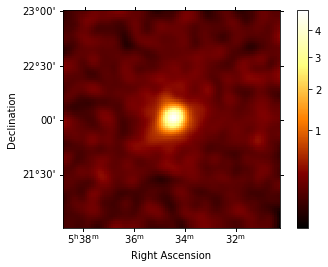

In [13]:
stacked.counts.sum_over_axes().smooth(0.05 * u.deg).plot(
    stretch="sqrt", add_cbar=True
)

## Save dataset to disk

It is common to run the preparation step independent of the likelihood fit, because often the preparation of maps, PSF and energy dispersion is slow if you have a lot of data. We first create a folder:

In [14]:
path = Path("analysis_2")
path.mkdir(exist_ok=True)

And then write the maps and IRFs to disk by calling the dedicated `~gammapy.datasets.MapDataset.write()` method:

In [15]:
filename = path / "crab-stacked-dataset.fits.gz"
stacked.write(filename, overwrite=True)

## Define the model
We first define the model, a `SkyModel`, as the combination of a point source `SpatialModel` with a powerlaw `SpectralModel`:

In [16]:
target_position = SkyCoord(ra=83.63308, dec=22.01450, unit="deg")
spatial_model = PointSpatialModel(
    lon_0=target_position.ra, lat_0=target_position.dec, frame="icrs"
)

spectral_model = PowerLawSpectralModel(
    index=2.702,
    amplitude=4.712e-11 * u.Unit("1 / (cm2 s TeV)"),
    reference=1 * u.TeV,
)

sky_model = SkyModel(
    spatial_model=spatial_model, spectral_model=spectral_model, name="crab"
)

Now we assign this model to our reduced dataset:

In [17]:
stacked.models.append(sky_model)

## Fit the model

The `~gammapy.modeling.Fit` class is orchestrating the fit, connecting the `stats` method of the dataset to the minimizer. By default, it uses `iminuit`.

Its contructor takes a list of dataset as argument.

In [18]:
%%time
fit = Fit([stacked])
result = fit.run(optimize_opts={"print_level": 1})

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 1.624e+04                  │       Ncalls = 143 (143 total)       │
│ EDM = 4.27e-06 (Goal: 0.0002)    │               up = 1.0               │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
CPU times: user 3.85 s, sys: 63.3 ms, total: 3.91 s
Wall time: 3.91 s


The `FitResult` contains information on the fitted parameters.

In [19]:
result.parameters.to_table()

name,value,unit,min,max,frozen,error
str9,float64,str14,float64,float64,bool,float64
norm,9.351e-01,,nan,nan,False,2.192e-02
tilt,0.000e+00,,nan,nan,True,0.000e+00
reference,1.000e+00,TeV,nan,nan,True,0.000e+00
index,2.600e+00,,nan,nan,False,1.004e-01
amplitude,4.587e-11,cm-2 s-1 TeV-1,nan,nan,False,3.702e-12
reference,1.000e+00,TeV,nan,nan,True,0.000e+00
lon_0,8.362e+01,deg,nan,nan,False,3.127e-03
lat_0,2.202e+01,deg,-9.000e+01,9.000e+01,False,2.973e-03


### Inspecting residuals

For any fit it is usefull to inspect the residual images. We have a few option on the dataset object to handle this. First we can use `.plot_residuals()` to plot a residual image, summed over all energies: 

/usr/share/miniconda/envs/gammapy-dev/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  return super().imshow(X, *args, origin=origin, **kwargs)


(<WCSAxesSubplot:xlabel='Right Ascension', ylabel='Declination'>, None)

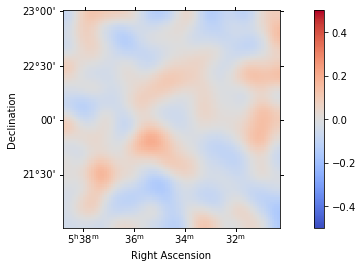

In [20]:
stacked.plot_residuals(method="diff/sqrt(model)", vmin=-0.5, vmax=0.5)

In addition we can aslo specify a region in the map to show the spectral residuals:

In [21]:
region = CircleSkyRegion(
    center=SkyCoord("83.63 deg", "22.14 deg"), radius=0.5 * u.deg
)

/usr/share/miniconda/envs/gammapy-dev/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  return super().imshow(X, *args, origin=origin, **kwargs)


(<WCSAxesSubplot:xlabel='Right Ascension', ylabel='Declination'>,
 <AxesSubplot:xlabel='Energy [TeV]', ylabel='Residuals ((data - model) / sqrt(model))'>)

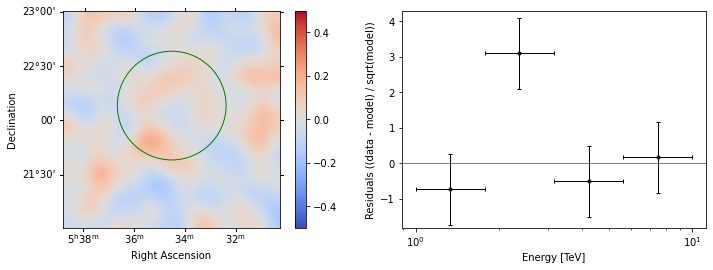

In [22]:
stacked.plot_residuals(
    region=region, method="diff/sqrt(model)", vmin=-0.5, vmax=0.5
)

We can also directly access the `.residuals()` to get a map, that we can plot interactively:

In [23]:
residuals = stacked.residuals(method="diff")
residuals.smooth("0.08 deg").plot_interactive(
    cmap="coolwarm", vmin=-0.1, vmax=0.1, stretch="linear", add_cbar=True
)

interactive(children=(SelectionSlider(continuous_update=False, description='Select energy:', layout=Layout(wid…

## Plot the fitted spectrum

### Making a butterfly plot 

The `SpectralModel` component can be used to produce a, so-called, butterfly plot showing the enveloppe of the model taking into account parameter uncertainties:

In [24]:
spec = sky_model.spectral_model

Now we can actually do the plot using the `plot_error` method:

/home/runner/work/gammapy-docs/gammapy-docs/gammapy/gammapy/modeling/models/spectral.py:329: MatplotlibDeprecationWarning: The 'nonposx' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_xscale("log", nonposx="clip")
/home/runner/work/gammapy-docs/gammapy-docs/gammapy/gammapy/modeling/models/spectral.py:330: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_yscale("log", nonposy="clip")


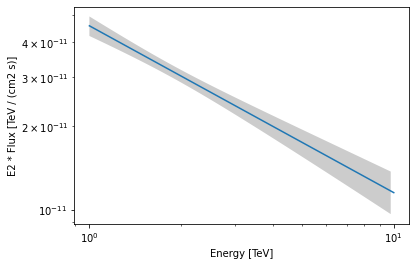

In [25]:
energy_range = [1, 10] * u.TeV
spec.plot(energy_range=energy_range, energy_power=2)
ax = spec.plot_error(energy_range=energy_range, energy_power=2)

### Computing flux points

We can now compute some flux points using the `~gammapy.estimators.FluxPointsEstimator`. 

Besides the list of datasets to use, we must provide it the energy intervals on which to compute flux points as well as the model component name. 

In [26]:
e_edges = [1, 2, 4, 10] * u.TeV
fpe = FluxPointsEstimator(e_edges=e_edges, source="crab")

In [27]:
%%time
flux_points = fpe.run(datasets=[stacked])

CPU times: user 2 s, sys: 27.9 ms, total: 2.03 s
Wall time: 2.03 s


/home/runner/work/gammapy-docs/gammapy-docs/gammapy/gammapy/modeling/models/spectral.py:329: MatplotlibDeprecationWarning: The 'nonposx' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_xscale("log", nonposx="clip")
/home/runner/work/gammapy-docs/gammapy-docs/gammapy/gammapy/modeling/models/spectral.py:330: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_yscale("log", nonposy="clip")
/home/runner/work/gammapy-docs/gammapy-docs/gammapy/gammapy/estimators/flux_point.py:668: MatplotlibDeprecationWarning: The 'nonposx' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_xscale("log", nonposx="clip")
/home/runner/work/gammapy-docs/gammapy-docs

<AxesSubplot:xlabel='Energy (TeV)', ylabel='dnde (TeV / (cm2 s))'>

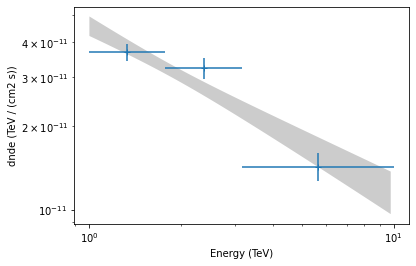

In [28]:
ax = spec.plot_error(energy_range=energy_range, energy_power=2)
flux_points.plot(ax=ax, energy_power=2)